Домашее задание номер 2. Взять произвольную аудиозапись. Получить ее мел спектрограмму (используя вашу реализацию!). Прогнать любой алгоритм шумоподавления (или написать свой!). И получить мелспектрограмму полученного сигнала. Посчитать метрики до и после.

In [38]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [39]:
def hz_to_mel(f_hz):
    f_hz = np.asarray(f_hz, dtype=float)
    return 2595.0 * np.log10(1.0 + f_hz / 700.0)

def mel_to_hz(m):
    m = np.asarray(m, dtype=float)
    return 700.0 * (10.0 ** (m / 2595.0) - 1.0)

def create_mel_filterbank(
    sr: int,
    n_fft: int,
    n_mels: int = 80,
    fmin: float = 0.0,
    fmax: float | None = None,
    use_slaney_norm: bool = True,
):
    if fmax is None:
        fmax = sr / 2.0

    m_min = hz_to_mel(fmin)
    m_max = hz_to_mel(fmax)
    m_points = np.linspace(m_min, m_max, n_mels + 2)
    f_points = mel_to_hz(m_points)

    fft_freqs = np.linspace(0, sr / 2.0, n_fft // 2 + 1)
    bin_indices = np.searchsorted(fft_freqs, f_points).astype(int)
    bin_indices = np.clip(bin_indices, 0, n_fft // 2)

    H = np.zeros((n_mels, n_fft // 2 + 1), dtype=float)

    for i in range(1, n_mels + 1):
        left = bin_indices[i - 1]
        center = bin_indices[i]
        right = bin_indices[i + 1]

        if center <= left:
            center = left + 1
        if right <= center:
            right = center + 1

        # up-slope
        H[i - 1, left:center] = (np.arange(left, center) - left) / (center - left)
        # down-slope
        H[i - 1, center:right] = (right - np.arange(center, right)) / (right - center)

    if use_slaney_norm:
        denom = (f_points[2:n_mels + 2] - f_points[:n_mels])
        denom = np.maximum(denom, 1e-12)  # защита от деления на ~0
        enorm = 2.0 / denom
        H *= enorm[:, np.newaxis]

    return H

def mel_spectrogram(
    x: np.ndarray,
    sr: int,
    win_length_ms: float = 25.0,
    hop_length_ms: float = 10.0,
    n_fft: int = 1024,
    n_mels: int = 80,
    fmin: float = 0.0,
    fmax: float | None = None,
    pre_emphasis: float | None = None,
    eps: float = 1e-10,
):
    x = np.asarray(x, dtype=np.float64)
    if x.ndim > 1:
        x = x.mean(axis=1)

    if pre_emphasis is not None and pre_emphasis != 0.0:
        y = np.empty_like(x)
        y[0] = x[0]
        y[1:] = x[1:] - pre_emphasis * x[:-1]
    else:
        y = x

    win_length = int(round(sr * win_length_ms / 1000.0))
    hop_length = int(round(sr * hop_length_ms / 1000.0))
    window = np.hanning(win_length)

    n_samples = len(y)
    if n_samples < win_length:
        y = np.pad(y, (0, win_length - n_samples), mode="constant")
    else:
        rest = (n_samples - win_length) % hop_length
        if rest != 0:
            y = np.pad(y, (0, hop_length - rest), mode="constant")

    n_samples = len(y)
    n_frames = 1 + (n_samples - win_length) // hop_length

    n_freqs = n_fft // 2 + 1
    P = np.empty((n_freqs, n_frames), dtype=np.float64)

    for i in range(n_frames):
        start = i * hop_length
        frame = y[start:start + win_length]
        frame_win = frame * window
        spectrum = np.fft.rfft(frame_win, n=n_fft)
        P[:, i] = np.abs(spectrum) ** 2

    H = create_mel_filterbank(
        sr=sr,
        n_fft=n_fft,
        n_mels=n_mels,
        fmin=fmin,
        fmax=fmax if fmax is not None else sr / 2.0,
        use_slaney_norm=True,
    )

    P = np.nan_to_num(P, nan=0.0, posinf=0.0, neginf=0.0)
    H = np.nan_to_num(H, nan=0.0, posinf=0.0, neginf=0.0)

    S_mel = H @ P
    S_mel = np.maximum(S_mel, 0.0)
    S_log = np.log(S_mel + eps)

    return S_log


In [40]:
audio_path = "acoustic-guitar.wav"

x, sr = sf.read(audio_path)
print(f"Файл: {audio_path}, sr = {sr}, shape = {x.shape}")

if x.ndim > 1:
    x = x.mean(axis=1)

x = x.astype(np.float64)
print("Моно shape:", x.shape)


Файл: acoustic-guitar.wav, sr = 44100, shape = (466560, 2)
Моно shape: (466560,)


In [41]:
def add_noise_snr(x: np.ndarray, snr_db: float, seed: int = 0):
    rng = np.random.default_rng(seed)
    x = np.asarray(x, dtype=np.float64)

    sig_power = np.mean(x**2) + 1e-12
    noise = rng.standard_normal(size=x.shape)
    noise = noise / (np.sqrt(np.mean(noise**2)) + 1e-12)

    noise_power_target = sig_power / (10**(snr_db / 10.0))
    noise = noise * np.sqrt(noise_power_target)

    x_noisy = x + noise
    return x_noisy

snr_in_db = 5.0
x_clean = x
x_noisy = add_noise_snr(x_clean, snr_in_db, seed=123)

print("Длины:", len(x_clean), len(x_noisy))


Длины: 466560 466560


In [42]:
def denoise_soft_spectral_subtraction(
    y: np.ndarray,
    sr: int,
    win_length_ms: float = 25.0,
    hop_length_ms: float = 10.0,
    n_fft: int = 2048,
    noise_time: float = 0.25,
    alpha: float = 1.5,
    floor: float = 0.02,
):
    y = np.asarray(y, dtype=np.float64)

    win_length = int(round(sr * win_length_ms / 1000.0))
    hop_length = int(round(sr * hop_length_ms / 1000.0))

    S = librosa.stft(
        y,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window="hann",
        center=True,
    )

    mag2 = np.abs(S) ** 2
    phase = np.angle(S)

    n_noise_frames = max(1, int((noise_time * sr) / hop_length))
    noise_psd = np.mean(mag2[:, :n_noise_frames], axis=1, keepdims=True)


    enh_mag2 = np.maximum(mag2 - alpha * noise_psd, floor * noise_psd)
    enh_mag = np.sqrt(enh_mag2)

    S_enh = enh_mag * np.exp(1j * phase)

    y_enh = librosa.istft(
        S_enh,
        hop_length=hop_length,
        win_length=win_length,
        window="hann",
        center=True,
        length=len(y),
    )

    return y_enh


win_length_ms = 25.0
hop_length_ms = 10.0
n_fft = 2048

x_denoised = denoise_soft_spectral_subtraction(
    x_noisy, sr,
    win_length_ms=win_length_ms,
    hop_length_ms=hop_length_ms,
    n_fft=n_fft,
    noise_time=0.25,
    alpha=1.5,
    floor=0.02,
)

print("Длины:", len(x_clean), len(x_noisy), len(x_denoised))


Длины: 466560 466560 466560


In [43]:
n_mels = 80
fmin = 20.0
fmax = min(8000, sr / 2)

mel_clean = mel_spectrogram(
    x_clean, sr,
    win_length_ms=win_length_ms,
    hop_length_ms=hop_length_ms,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=fmin,
    fmax=fmax,
    pre_emphasis=0.97,
)

mel_noisy = mel_spectrogram(
    x_noisy, sr,
    win_length_ms=win_length_ms,
    hop_length_ms=hop_length_ms,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=fmin,
    fmax=fmax,
    pre_emphasis=0.97,
)

mel_denoised = mel_spectrogram(
    x_denoised, sr,
    win_length_ms=win_length_ms,
    hop_length_ms=hop_length_ms,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=fmin,
    fmax=fmax,
    pre_emphasis=0.97,
)

mel_clean.shape, mel_noisy.shape, mel_denoised.shape


((80, 1057), (80, 1057), (80, 1057))

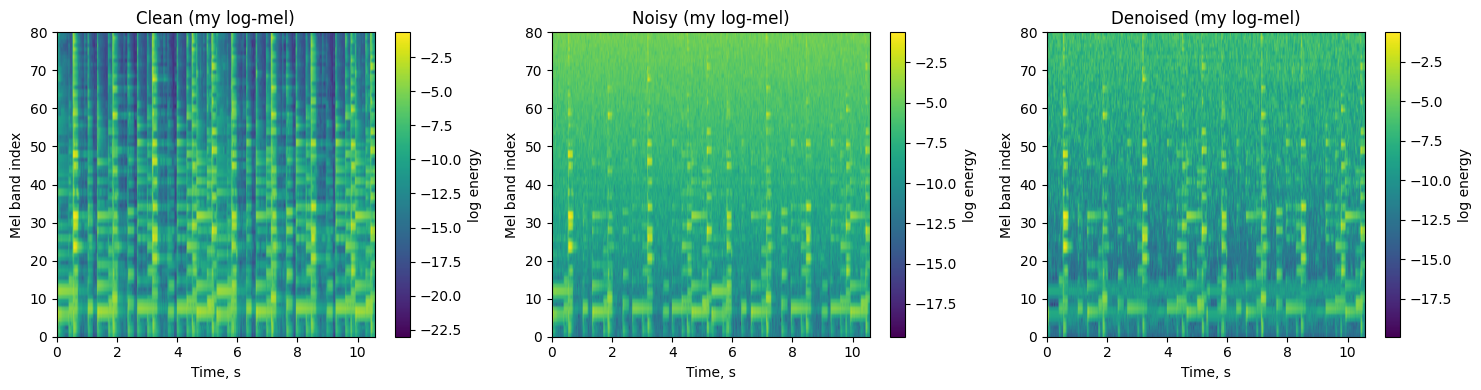

In [44]:
def plot_mel(mel, sr, hop_length_ms, title):
    n_mels, n_frames = mel.shape
    hop_length = int(round(sr * hop_length_ms / 1000.0))
    duration_sec = n_frames * hop_length / sr

    plt.imshow(
        mel,
        origin="lower",
        aspect="auto",
        extent=[0, duration_sec, 0, n_mels],
    )
    plt.xlabel("Time, s")
    plt.ylabel("Mel band index")
    plt.title(title)
    plt.colorbar(label="log energy")

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plot_mel(mel_clean, sr, hop_length_ms, "Clean (my log-mel)")

plt.subplot(1, 3, 2)
plot_mel(mel_noisy, sr, hop_length_ms, "Noisy (my log-mel)")

plt.subplot(1, 3, 3)
plot_mel(mel_denoised, sr, hop_length_ms, "Denoised (my log-mel)")

plt.tight_layout()
plt.show()


In [45]:
def snr_db(ref: np.ndarray, est: np.ndarray, eps: float = 1e-12) -> float:
    ref = np.asarray(ref, dtype=np.float64)
    est = np.asarray(est, dtype=np.float64)
    e = est - ref
    return 10.0 * np.log10((np.sum(ref**2) + eps) / (np.sum(e**2) + eps))

def si_sdr_db(ref: np.ndarray, est: np.ndarray, eps: float = 1e-8) -> float:
    ref = np.asarray(ref, dtype=np.float64)
    est = np.asarray(est, dtype=np.float64)

    ref = ref - ref.mean()
    est = est - est.mean()

    alpha = np.dot(est, ref) / (np.dot(ref, ref) + eps)
    target = alpha * ref
    noise = est - target

    return 10.0 * np.log10((np.sum(target**2) + eps) / (np.sum(noise**2) + eps))

def mel_l1(m1, m2):
    T = min(m1.shape[1], m2.shape[1])
    return float(np.mean(np.abs(m1[:, :T] - m2[:, :T])))

metrics = {
    "SNR (dB)": (snr_db(x_clean, x_noisy), snr_db(x_clean, x_denoised)),
    "SI-SDR (dB)": (si_sdr_db(x_clean, x_noisy), si_sdr_db(x_clean, x_denoised)),
    "Mel L1 distance": (mel_l1(mel_clean, mel_noisy), mel_l1(mel_clean, mel_denoised)),
}

df = pd.DataFrame(
    [(k, v[0], v[1], v[1] - v[0]) for k, v in metrics.items()],
    columns=["Metric", "Before", "After", "Delta (After-Before)"]
)
df


,Metric,Before,After,Delta (After-Before)
0,SNR (dB),5.000000,6.069155,1.069155
1,SI-SDR (dB),4.977833,4.992891,0.015057
2,Mel L1 distance,4.031731,3.143946,-0.887785


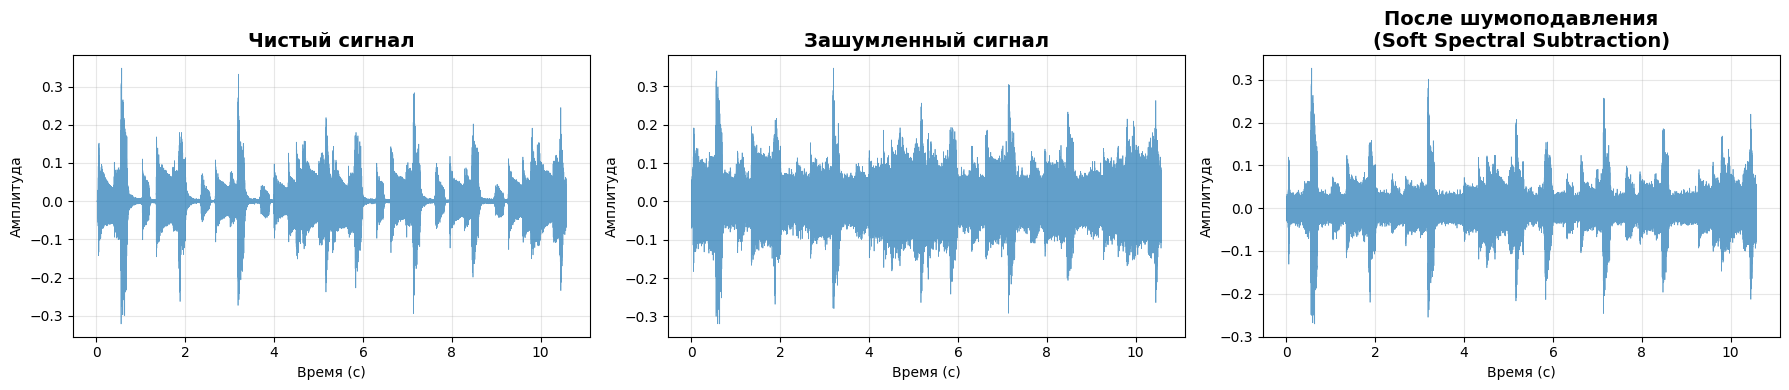

In [46]:
fig_signals, axes_signals = plt.subplots(1, 3, figsize=(18, 4))

t = np.arange(len(x_clean)) / sr

axes_signals[0].plot(t, x_clean, alpha=0.7, linewidth=0.5)
axes_signals[0].set_title("Чистый сигнал", fontsize=14, fontweight="bold")
axes_signals[0].set_xlabel("Время (с)")
axes_signals[0].set_ylabel("Амплитуда")
axes_signals[0].grid(True, alpha=0.3)

axes_signals[1].plot(t, x_noisy, alpha=0.7, linewidth=0.5)
axes_signals[1].set_title("Зашумленный сигнал", fontsize=14, fontweight="bold")
axes_signals[1].set_xlabel("Время (с)")
axes_signals[1].set_ylabel("Амплитуда")
axes_signals[1].grid(True, alpha=0.3)

axes_signals[2].plot(t, x_denoised, alpha=0.7, linewidth=0.5)
axes_signals[2].set_title("После шумоподавления\n(Soft Spectral Subtraction)", fontsize=14, fontweight="bold")
axes_signals[2].set_xlabel("Время (с)")
axes_signals[2].set_ylabel("Амплитуда")
axes_signals[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
